In [1]:
import pandas as pd
import numpy as np
import librosa
import seaborn as sns
import os
import json
import IPython.display as ipd
import soundfile as sf
import math
import h5py

from glob import glob
from tqdm import tqdm
from matplotlib import pyplot as plt
from itertools import chain
from os.path import join as pjoin
from shutil import copyfile
from copy import deepcopy

from code_base.utils import write_json, load_json

/backup/vova/src/exps/bird_clef_2024/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Original Class Weights from Train Data

In [2]:
df = pd.read_csv("/home/vova/data/exps/birdclef_2024/birdclef_2024/train_metadata_extended_noduplv1.csv")

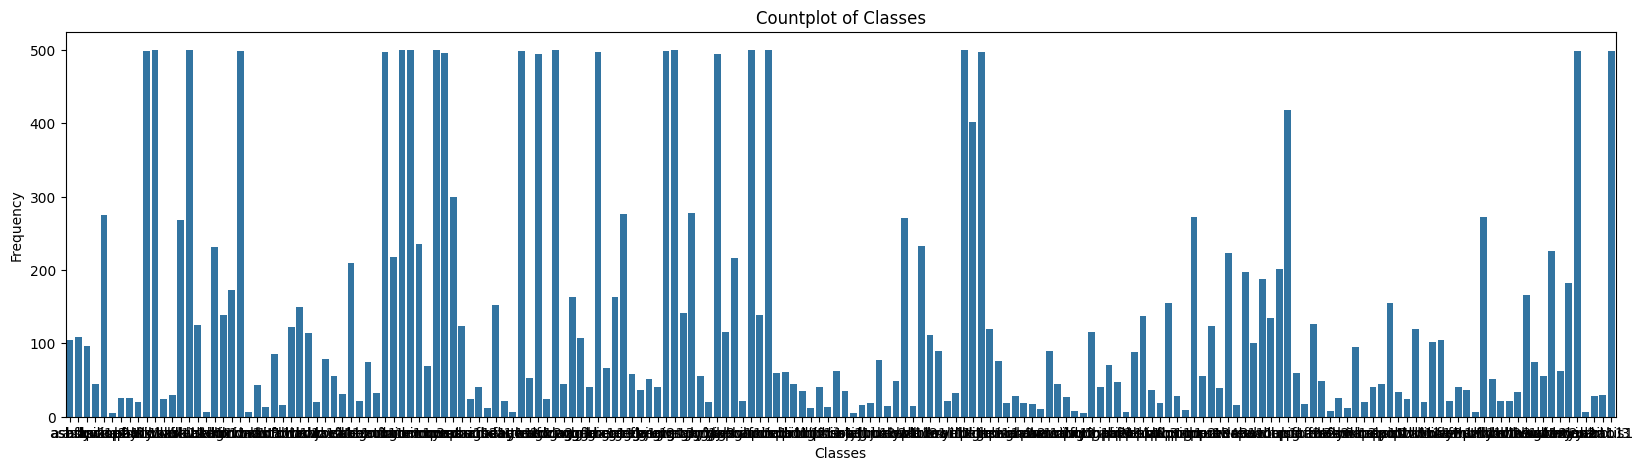

In [15]:
plt.figure(figsize=(20,5))

# Create a countplot
sns.countplot(x=df["primary_label"])

# Set title and labels
plt.title('Countplot of Classes')
plt.xlabel('Classes')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [9]:
weights_to_check = load_json("/home/vova/data/exps/birdclef_2024/sample_weights/sw_2024_add_data_v1.json")

In [8]:
original_dist_weight = (df["primary_label"].value_counts() / df["primary_label"].value_counts().sum()).to_dict()

In [12]:
write_json("/home/vova/data/exps/birdclef_2024/sample_weights/sw_in_2024_train.json", original_dist_weight)

# 2024 Scored Data DF

In [ ]:
train_metadata = pd.read_csv("/home/vova/data/exps/birdclef_2024/birdclef_2024/train_metadata_extended_noduplv1.csv", converters={"secondary_labels":eval, "all_labels": eval})
train_metadata_prev_comp = pd.read_csv("/home/vova/data/exps/birdclef_2024/dfs/full_noduplsV3_scored_meta_prev_comps_extended_2024SecLabels.csv", converters={"secondary_labels":eval, "all_labels": eval})
train_metadata_xeno_canto = pd.read_csv("/home/vova/data/exps/birdclef_2024/xeno_canto/dataset_2024_classes/train_metadata_noduplV3_extended_2024SecLabels.csv", converters={"secondary_labels":eval, "all_labels": eval})

In [ ]:
scored_birds = load_json("/home/vova/data/exps/birdclef_2024/scored_birds/sb_2024.json")

In [ ]:
def extract_sampler_col(row, scored_birds_):
    if row["primary_label"] in scored_birds_:
        return row["primary_label"]
    else:
        return list(set(row["secondary_labels"]) & set(scored_birds_))[0]

In [ ]:
train_metadata_prev_comp["stratify_col"] = train_metadata_prev_comp.apply(
    lambda row: extract_sampler_col(row, scored_birds),
    axis=1
)

In [ ]:
train_metadata["stratify_col"] = train_metadata["primary_label"]
train_metadata_xeno_canto["stratify_col"] = train_metadata_xeno_canto["primary_label"]

In [ ]:
train_metadata_prev_comp["stratify_col"].apply(lambda x: x in scored_birds).all()

In [ ]:
# train_metadata_prev_comp.to_csv(
#     "/home/vova/data/exps/birdclef_2024/dfs/full_noduplsV2_scored_meta_prev_comps_extended.csv",
#     index=False
# )

In [ ]:
# train_metadata.to_csv(
#     "/home/vova/data/exps/birdclef_2024/birdclef_2024/train_metadata_extended.csv",
#     index=False
# )

In [ ]:
# train_metadata_xeno_canto.to_csv(
#     "/home/vova/data/exps/birdclef_2024/xeno_canto/dataset_2024_classes/train_metadata_nodupl_extended.csv",
#     index=False
# )

In [ ]:
all_labels = pd.concat([
    train_metadata["primary_label"], train_metadata_prev_comp["stratify_col"], train_metadata_xeno_canto["primary_label"]
]).reset_index(drop=True)

## "Power" Balanced

In [ ]:
sample_weights = (all_labels.value_counts() / all_labels.value_counts().sum())  ** (-0.5)

In [ ]:
sample_weights

In [ ]:
write_json("/home/vova/data/exps/birdclef_2024/sample_weights/sw_2024_add_data_v1.json", sample_weights.to_dict())

# Simple Balanced

In [ ]:
all_labels = pd.concat([
    train_metadata["stratify_col"], train_metadata_prev_comp["stratify_col"], train_metadata_xeno_canto["stratify_col"]
]).reset_index(drop=True)

In [ ]:
sample_weights = (all_labels.value_counts() / all_labels.value_counts().sum()) ** (-1)

In [ ]:
all_labels.value_counts()

In [ ]:
sample_weights

In [ ]:
write_json("/home/vova/data/exps/birdclef_2024/sample_weights/sw_2024_add_data_v2_bal.json", sample_weights.to_dict())

# 2024 + 2024 Scored from XC + Prev Comps

In [ ]:
train_metadata = pd.read_csv("/home/vova/data/exps/birdclef_2024/birdclef_2024/train_metadata_extended_noduplv1.csv", converters={"secondary_labels":eval, "all_labels": eval})
train_metadata_prev_comp = pd.read_csv("/home/vova/data/exps/birdclef_2024/dfs/full_noduplsV2_meta_prev_comps_extended_pruned.csv", converters={"secondary_labels":eval, "all_labels": eval})
train_metadata_xeno_canto = pd.read_csv("/home/vova/data/exps/birdclef_2024/xeno_canto/dataset_2024_classes/train_metadata_noduplV3_extended.csv", converters={"secondary_labels":eval, "all_labels": eval})

In [ ]:
all_labels = pd.concat([
    train_metadata["primary_label"], train_metadata_prev_comp["primary_label"], train_metadata_xeno_canto["primary_label"]
]).reset_index(drop=True)

In [ ]:
sample_weights = (all_labels.value_counts() / all_labels.value_counts().sum())  ** (-0.5)

In [ ]:
write_json("/home/vova/data/exps/birdclef_2024/sample_weights/sw_2024_PrevComp_v1.json", sample_weights.to_dict())

In [ ]:
sample_weights

In [ ]:
all_labels.isna().sum()